In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import  seaborn as sns

from Utils import sigmoid
from ExperientalTools import *

import warnings
warnings.filterwarnings("ignore", "is_categorical_dtype")
warnings.filterwarnings("ignore", "use_inf_as_na")
%reload_ext autoreload
%autoreload 2

# JUST AN EXAMPLE

In [3]:
(tr_x,tr_y), (vl_x,vl_y), (ts_x,ts_y) = prepare_dataset(train_path="datasets/ML-CUP21-TR.csv")

In [4]:
instance = fit_cholesky(tr_x,tr_y, hidden=100,lambda_=0, activation=sigmoid)

In [5]:
get_results(instance,vl_x,vl_y)

2.1613235500075394

In [6]:
instance = fit_fista(tr_x,tr_y, hidden=500, lambda_=0, max_inters=10000, activation=sigmoid)

In [7]:
mse_errors =pd.DataFrame(instance[1],columns=["MSE errors"])
mse_errors["iterations"] = mse_errors.index

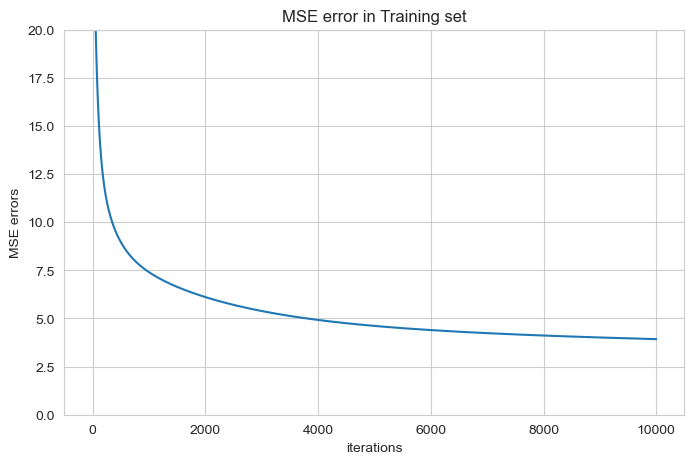

In [8]:
f, axs = plt.subplots(figsize=(8,5))
sns.lineplot(data=mse_errors, x="iterations", y="MSE errors", ax=axs)
axs.set_ylim([0,20])
axs.set_title("MSE error in Training set")
plt.show()

# GRIDSEARCH CHOLESKY

In [9]:
parameter_grid = dict(
    hidden=[*range(10,500,10)],
    regularization =  [1e-01, 5e-02, 1e-02, 5e-03, 1e-03],
    activation_fun = [sigmoid]
)
GridSearch_cholesky("datasets/ML-CUP21-TR.csv",configs=parameter_grid)

100%|██████████| 245/245 [01:22<00:00,  2.98it/s, minMSE=1.83]


The best configuration is  {'activation_fun': <function sigmoid at 0x000001B6C805F880>, 'hidden': 340, 'regularization': 0.01}
Train error  1.2490748388061064  Validation error 1.830013853649577


# GRIDSEARCH FISTA

In [10]:
parameter_grid = dict(
    hidden=[*range(10,500,10)],
    regularization =  [1e-01, 5e-02, 1e-02, 5e-03, 1e-03],
    activation_fun = [sigmoid],
    max_iter=[10000]
)
GridSearch_fista("datasets/ML-CUP21-TR.csv",configs=parameter_grid)

  0%|          | 0/245 [00:00<?, ?it/s]K:\NoSyncProject\ExtremeLearningNN\Utils.py:30: RuntimeWarning: overflow encountered in power
  return np.power((y - y_pred), 2).mean()
C:\Users\Andrea\anaconda3\envs\GeneralPurpose\Lib\site-packages\numpy\core\_methods.py:118: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
K:\NoSyncProject\ExtremeLearningNN\ExtremeNN.py:75: RuntimeWarning: overflow encountered in matmul
  y_pred = self.w2 @ h
K:\NoSyncProject\ExtremeLearningNN\ExtremeNN.py:67: RuntimeWarning: overflow encountered in matmul
  grad_zk = (z_k @ h - y) @ h.T
K:\NoSyncProject\ExtremeLearningNN\ExtremeNN.py:66: RuntimeWarning: invalid value encountered in subtract
  z_k = w2_old + c * (self.w2 - w2_old)
 18%|█▊        | 43/245 [00:41<03:16,  1.03it/s, minMSE=9.22e+18]


KeyboardInterrupt: 